# Pathfinder tests

The goal of this module is to test the functionality of the pathfinder modules using the pre-saved data from the fullscan pathfinder.

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import json
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..\\')
from Pathfinders import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Unload the data from a particular scan
This should only include data from a Fullscan module

In [72]:
path = os.path.abspath('..\\')
test_no = 6
# current_file = r"\Debugging Scripts\Scans\test_%s.json" % test_no
current_file = r"\Scans\test_%s.json" % test_no

debug_mode = True

### JSON Unpacking
Using the above file number and path, the scan data is unpacked from the corresponding JSON file. Unpacking the data can take around ~15 seconds depending on the length of the file, so a #TODO item is to create code for running a pathfinder directly off a math equation.

In [73]:
with open(path + current_file, 'r') as infile:
    json_data = json.load(infile)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
point_mags = json_data["points"]
scan_max = json_data["max_point"]

# indices = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
# points = np.array([[p[0][indices[a][0]][indices[a][1]] for a in active_rom] for p in point_mags])
# mags = np.array([p[1] for p in point_mags])

points = np.array([p[0] for p in point_mags])
mags = np.array([[p[1] for p in point_mags]])
mags = mags.T
points = np.reshape(points,(points.shape[0],6))

data = pd.DataFrame(data=np.hstack((points,mags)), columns=["X","Y","Z","Rx","Ry","Rz","mag"])

active_rom = []
for DoF in r_o_m:
    if r_o_m[DoF] != [0,0]:
        active_rom.append(DoF)
    else:
        data.drop(DoF, inplace=True, axis=1)


points = data[active_rom]
mags = data['mag']
mp = data.loc[data['mag'].idxmax()]

In [228]:
print(points.shape)
print(mags.shape)
linInter = LinearNDInterpolator(points, mags,fill_value=-1)

r = dict()
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2

p_dict = dict()
for p in point_mags:
    p_dict[(tuple(p[0][0]),tuple(p[0][1]))] = p[1]

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(point_mags[0])
    print(type(point_mags))
    print(r_o_m)
    print(np.shape(points))
    print(r)
    print(resolution)

(51749, 3)
(51749,)
Active range of motion: ['Z', 'Rx', 'Ry']
[[[0.0, 0.0, -14.0], [-13.0, -12.0, 0.0]], 216.071]
<class 'list'>
{'X': [0, 0], 'Y': [0, 0], 'Z': [-14.0, 14.0], 'Rx': [-13.0, 13.0], 'Ry': [-13.0, 13.0], 'Rz': [0, 0]}
(51749, 3)
{'X': 0.0, 'Y': 0.0, 'Z': 14.0, 'Rx': 13.0, 'Ry': 13.0, 'Rz': 0.0}
[0.4, 1]


In [237]:
# scanner = Discrete_degree(r['Z'], r['Rx'], r['Ry'])
# scanner = DivisionDiscreteDegree(4, r['Z'], r['Rx'], r['Ry'], cutoff_mag=50)
scanner = Greedy_discrete_degree(r['Z'], r['Rx'], r['Ry'],bias=2,steps=4)

p = scanner.next()
i = 0

indices = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
offset = {'X': 0., 'Y': 0., 'Z': -9., 'Rx': -8., 'Ry': 8., 'Rz': 0.}

while p != 1 and i < 10000:
    i += 1

    request = np.array([p[indices[a][0]][indices[a][1]] + offset[a] for a in active_rom])
    mag = linInter(request)

    if mag[0] == -1:
        mag[0] = i * -20
    # print((p,mag[0]))

    scanner.newMag((p, mag[0]), True)
    p = scanner.next()

if debug_mode:
    print(f"Number of points to solve: {i}")
    # print(path + output_file)
r_o_m = scanner.range_of_motion
point_mags_2 = scanner.points
search_max = scanner.max_point
active_rom = scanner.active_rom

print(len(point_mags_2))

scanner_points = np.array([p[0] for p in point_mags_2])
scanner_mags = np.array([[p[1] for p in point_mags_2]])
scanner_mags = scanner_mags.T
scanner_points = np.reshape(scanner_points,(scanner_points.shape[0],6))

scanner_data = pd.DataFrame(data=np.hstack((scanner_points,scanner_mags)), columns=["X","Y","Z","Rx","Ry","Rz","mag"])

for DoF in r_o_m:
    if r_o_m[DoF] == [0,0]:
        scanner_data.drop(DoF, inplace=True, axis=1)
    else:
        scanner_data[DoF] = scanner_data[DoF] + offset[DoF]


print(scanner_data.head())
a = point_mags_2[0][0]
distance = 0

for i in range(1, len(point_mags_2)):
    b = point_mags_2[i][0]
    t = 0
    for j in range(3):
        t += (a[0][j] - b[0][j])**2
        t += (a[1][j] - b[1][j])**2

    distance += t**0.5
    a = b

(((x,y,z),(Rx,Ry,Rz)),mag) = search_max
search_max = (((x+offset['X'],y+offset['Y'],z+offset['Z']),(Rx+offset['Rx'],Ry+offset['Ry'],Rz+offset['Rz'])),mag)

for j in range(3):
    t += (scan_max[0][0][j] - search_max[0][0][j])**2

degree_dist = np.arccos(np.cos(np.deg2rad(scan_max[0][1][0] - search_max[0][1][0])) * np.cos(np.deg2rad(scan_max[0][1][1] - search_max[0][1][1])))
lin_dist = t**0.5

print("Pathfinder evalutation: ")
print(f"\tTotal search-space distance traveled: {distance}")
print(f"\tScan max value: {scan_max}")
print(f"\tSearch max value: {search_max}")
print(f"\tOffsets: {offset}")
print(f"\tDistance from target to found value: {lin_dist} mm, {degree_dist} deg")

1.6
0.8
0.4
0.2
0.1
Number of points to solve: 240
240
      Z   Rx   Ry       mag
0  -9.0 -8.0  8.0   38.4535
1 -10.6 -8.0  8.0   37.1565
2 -12.2 -8.0  8.0   40.8950
3 -13.8 -8.0  8.0   39.6740
4 -15.4 -8.0  8.0 -100.0000
Pathfinder evalutation: 
	Total search-space distance traveled: 275.1487836567428
	Scan max value: [[[0.0, 0.0, 2.400000000000002], [0.0, 1.0, 0.0]], 621.204]
	Search max value: (((0.0, 0.0, 2.3999999999999986), (0.0, 1.0000000000000036, 0.0)), 621.2040000000006)
	Offsets: {'X': 0.0, 'Y': 0.0, 'Z': -9.0, 'Rx': -8.0, 'Ry': 8.0, 'Rz': 0.0}
	Distance from target to found value: 0.09999999999999964 mm, 0.0 deg


(-16.0, 9.599999999999998)
(-14.40000000000001, 12.8)
(-20.2, 10.2)


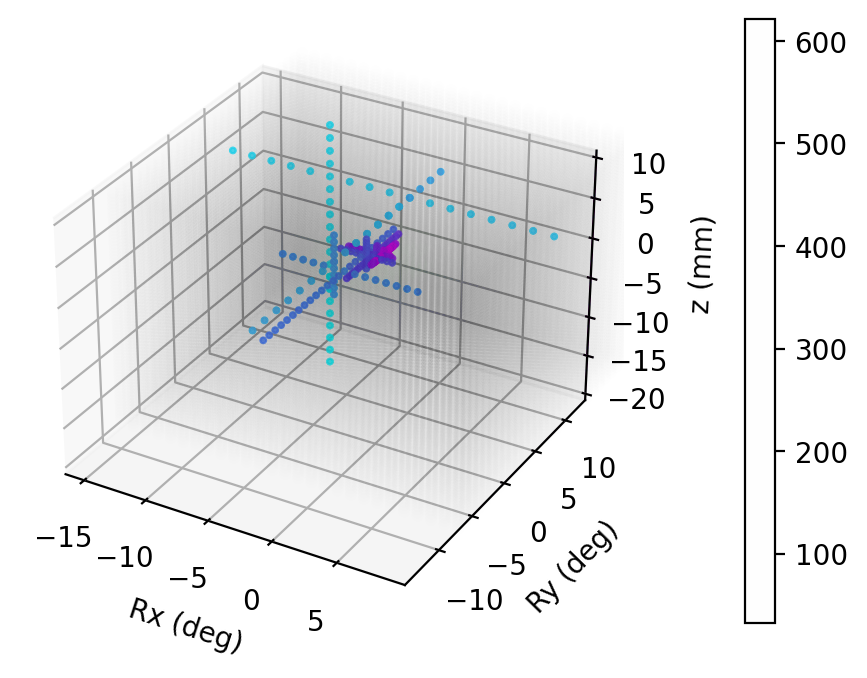

In [239]:
ax = plt.axes(projection='3d')
fig = ax.scatter(data['Rx'], data['Ry'], data['Z'], c=data['mag'], cmap='viridis', alpha=0.005, linewidth=0.05)
plt.colorbar(fig, pad=0.13,alpha=1)

# fig = ax.scatter(Rxs1, Rys1, Zs1, c=range(len(Zs1)), cmap='binary', alpha=0.8, linewidth=0.8, s=4)
fig = ax.scatter(scanner_data['Rx'], scanner_data['Ry'], scanner_data['Z'], c=range(len(scanner_data)), cmap='cool', alpha=0.8, linewidth=0.8, s=4)

ax.set_xlabel("Rx (deg)")
ax.set_ylabel("Ry (deg)")
ax.set_zlabel("z (mm)")
plt.rcParams['figure.dpi'] = 200

print((min(scanner_data['Rx']),max(scanner_data['Rx'])))
print((min(scanner_data['Ry']),max(scanner_data['Ry'])))
print((min(scanner_data['Z']),max(scanner_data['Z'])))


ax.set_xbound((min(scanner_data['Rx']),max(scanner_data['Rx'])))
ax.set_ybound((min(scanner_data['Ry']),max(scanner_data['Ry'])))
ax.set_zbound((min(scanner_data['Z']),max(scanner_data['Z'])))

# plt.savefig("fullscan_render.jpg", dpi=400)
plt.show()
# plt.axes(projection = "3d")
# plt.scatter(Rxs, Rys, Zs, c=mags, cmap='viridis', alpha=0.8, linewidth=0.5)
